In [ ]:
import warnings
import matplotlib.pyplot as plt
import numpy as np

import scipy.stats as st
from scipy.stats import probplot
from scipy.stats import anderson, shapiro

warnings.simplefilter("ignore")

## 1. Статистические распределения

### 1.1. Нормальное распредление

Нормальное распределение - распределение, которое задается двумя параметрами:

$$X \sim N(\mu, \sigma^2)$$

$\mu$ - среднее значение, $\sigma$ - стандартное отклонение;

Нормальное распределение - распределение вероятностей, которое в одномерном случае задается функцией плотности вероятности, совпадающей с функцией Гаусса:

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/b77e66e0cfdc9859e63d68b5309bb794ad7cd1aa">

__Стандартным__ нормальным распределением называется нормальное распределение с математическим ожиданием $\mu$ = 0 и стандартным отклонением $\sigma$ = 1.

In [36]:
mu, sigma = 0.5, 0.1
distributions = [
    np.random.normal(mu, sigma, 1000),
    np.random.normal(10*mu, sigma, 1000),
    np.random.normal(10*mu, 100*sigma, 1000),
    np.random.normal(mu, 100*sigma, 1000)
]

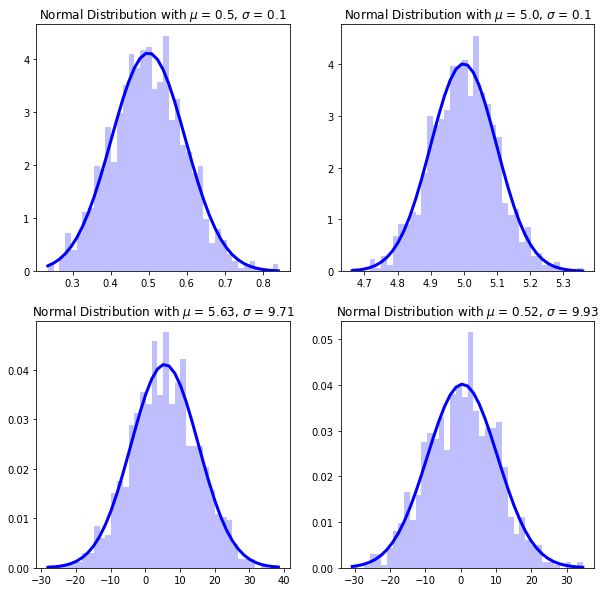

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for num, data in enumerate(distributions):
    count, bins, ignored = axes[num//2, num%2].hist(
        data, bins=40, normed=True, color="blue", alpha=0.25)

    mu, sigma = data.mean(), data.std()
    stat = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(bins - mu)**2 / (2 * sigma**2))
    axes[num//2, num%2].plot(bins, stat, linewidth=3, color="blue")
    axes[num//2, num%2].set_title(
        f"Normal Distribution with $\mu$ = {round(mu, 2)}, $\sigma$ = {round(sigma, 2)}"
    )

## 2. Проверка гипотезы о нормальности распределения выборки

Большая часть методов математической статистики связана с данными, которые предполагают, что они были взяты из нормального распределения. Если используются методы, предполагающие нормальное распределение, а данные взяты из другого распределения, результаты могут быть вводящими в заблуждение или просто ошибочными.

Существует ряд методов, которые можно проверить, является ли выборка данных нормальной или достаточно нормальной, чтобы использовать стандартные методы, или достаточно ненормальной, чтобы вместо этого использовать непараметрические статистические методы.

In [38]:
norm_data = np.random.randn(1000)
another_data = np.random.randint(0, 100, size=1000)

### 2.1. Визуальная проверка 

Самым простым и быстрым способ для проверки нормальности распределения выборки - использование визуализации. Эти проверки являются качественными, поэтому менее точными, чем статистические методы, которые мы рассчитаем в следующем разделе. Тем не менее, они быстрые и, как и статистические тесты, все равно должны быть интерпретированы.

### 2.1.1. Гистограмма

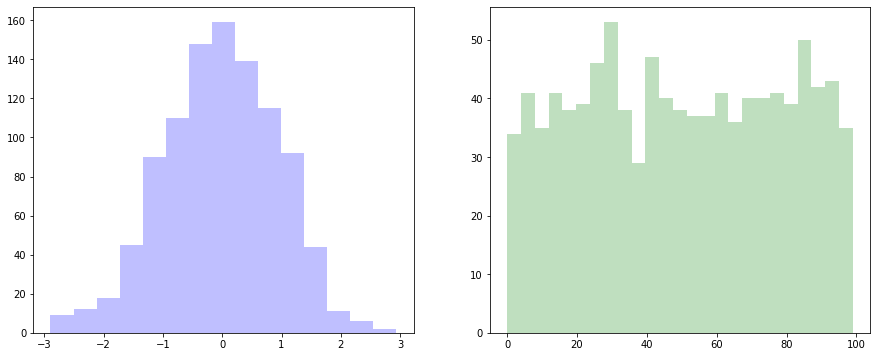

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].hist(norm_data, bins=15, color="blue", alpha=0.25)
axes[1].hist(another_data, bins=25, color="green", alpha=0.25)

plt.show()

### 2.1.2. QQ-plot / Quantile-Quantile Plot

Очень удобный способ визуальной проверки предположения нормальности — `Q-Q` график. Чтобы построить такой график, выборку нужно превратить в вариационный ряд, то есть отсортировать по неубыванию, а дальше каждому объекту выборки сопоставить точку на графике. Значение по вертикальной оси соответствует значению `X`, а значение по горизонтальной оси — математическому ожиданию квантиля стандартного нормального распределения, посчитанного по выборке такого объема. Если выборка взята из нормального распределения, точки на `Q-Q` графике должны лежать примерно на диагонале. Если точки лучше описываются нелинейной кривой или какие-то из точек лежат от прямой очень далеко, скорее всего, распределение отличается от нормального.

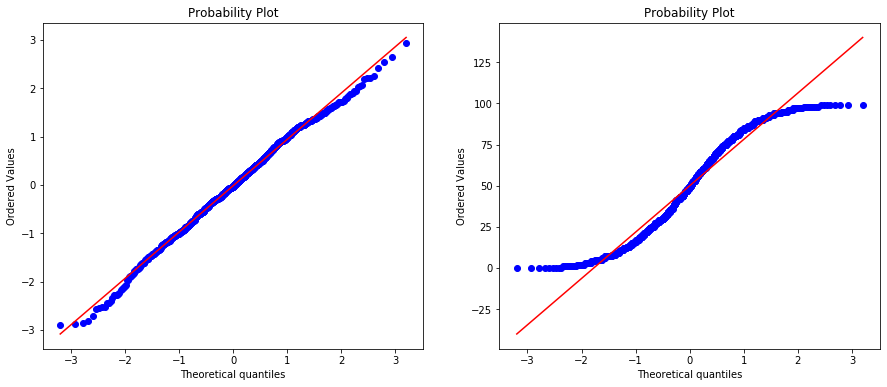

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

probplot(x=norm_data, plot=axes[0])
probplot(x=another_data, plot=axes[1])
plt.show()

### 2.2. Статистические тесты нормальности

Существует много статистических тестов, которые мы можем использовать для количественной оценки того, выглядит ли выборка данных так, как будто она получена из нормального распределения. Каждый тест делает разные предположения и рассматривает разные аспекты данных.

Каждый тест возвращает:

* __статистика__: функция, посчитанная по выборке, которую можно интерпретировать в контексте теста, сравнивая его с критическими значениями из распределения статистики теста.

* __р-значение__: используется для интерпретации теста, в данном случае, была ли выборка получена из нормального распределения.


Каждый тест вычисляет статистику конкретного теста. Эта статистика может помочь в интерпретации результата, хотя может потребовать более глубокого знания статистики и более глубокого знания конкретного статистического теста. Вместо этого можно использовать значение `p-value` для быстрого и точного интерпретации статистики в практических приложениях. Тесты предполагают, что выборка из нормального распределения. Технически это называется __нулевой гипотезой__, или $H_0$. Выбран достигаемый уровень значимости, называемый альфа, обычно 5% (или 0,05), который используется для интерпретации значения `p-value`.

$x$ = ($x_1$, $x_2$, ..., $x_n$), $x \in X$

__$H_0$__: $x \sim X(\mu, \sigma^2)$

__$H_1$__: $H_0$ неверна

### 2.2.1. Тест Шапиро-Уилка

На практике тест Шапиро-Уилка считается надежным тестом нормальности, хотя есть некоторые предположения, что этот тест может быть пригоден для небольших выборок данных, например, тысячи наблюдений или меньше.

In [44]:
norm_data = np.random.randn(100)
stats, p_value = shapiro(x=norm_data)
print(f"Значение статистики = {round(stats, 2)}, p_value = {round(p_value, 5)}")

Значение статистики = 0.97, p_value = 0.05252


In [43]:
stats, p_value = shapiro(x=another_data)
print(f"Значение статистики = {round(stats, 2)}, p_value = {round(p_value, 5)}")

Значение статистики = 0.95, p_value = 0.0


###  2.3. Какой инструмент использовать для проверки гипотезы о нормальном распределении?

В итоге предлагается использовать следующий алгоритм. Если анализируемые данные имеют распределение, явно отличающееся от нормального (например, выборка бинарна или измеряемый признак — категориальный), не нужно применять метод, предполагающий нормальность. Лучше использовать метод, специально разработанный для такого распределения. Если исследуемый признак, по крайней мере, измерен в непрерывной шкале, можно построить `Q-Q` график. Если на этом графике не видно существенных отклонений от нормальности (точки лежат примерно на прямой), можно использовать методы, устойчивые к небольшим отклонениям от нормальности. Если используемый метод чувствителен к отклонениям от нормальности, необходимо формально проверить нормальность, и рекомендуется это делать с помощью метода Шапиро-Уилка. Показано, что критерий Шапиро-Уилка обладает достаточно хорошей мощностью для разных классов альтернатив. Если критерий Шапиро-Уилка отвергает нормальность, не нужно использовать методы, чувствительные к отклонениям от нормальности.

## 3. Параметрические критерии

В этом разделе, поговорим про параметрические критерии. Эти критерии называются параметрическими потому, что в проверяемых ими гипотезах высказывается предположение о значении параметра распределений, из которых предположительно взята выборка.

### 3.1. Одновыборочный критерий Стьюдента

Семейство критериев Стьюдента позволяет проверять гипотезы о математических ожиданиях нормальных распределений.

__Пример:__ Средний вес детей при рождении составляет 3300 г, а стандартное отклонение - 200 г. В то же время, если мать ребёнка живёт за чертой бедности, то средний вес таких детей — 2800 г. Вес при рождении — это очень важный показатель здоровья ребенка. Так, только 7% детей рождаются с весом меньше 2.5 кг, однако на них приходится 70% детских смертей. С целью увеличить вес тех детей, чьи матери живут за чертой бедности, разработана экспериментальная программа ведения беременности. Чтобы проверить ее эффективность, проводится эксперимент. В нем принимают участие 25 женщин, живущих за чертой бедности. У всех них рождаются дети, и их средний вес составляет 3075 г. Для того, чтобы ответить на вопрос, эффективна ли программа, используется критерий Стьюдента.

<img src="images/student.png" width=400 height=400 />

In [45]:
mu_0 = 3300
x_mean = 3075
n = 25
sigma = 200

stats = np.sqrt(n) * (x_mean - mu_0) / sigma
p_value = st.norm.pdf(stats)

print(f"p_value = {round(p_value, 4)}")

p_value = 0.0


### 3.2. Двухвыборочный критерий Стьюдента для независимых выборок

<img src="images/web10_student_two.png" width=400 height=400 />

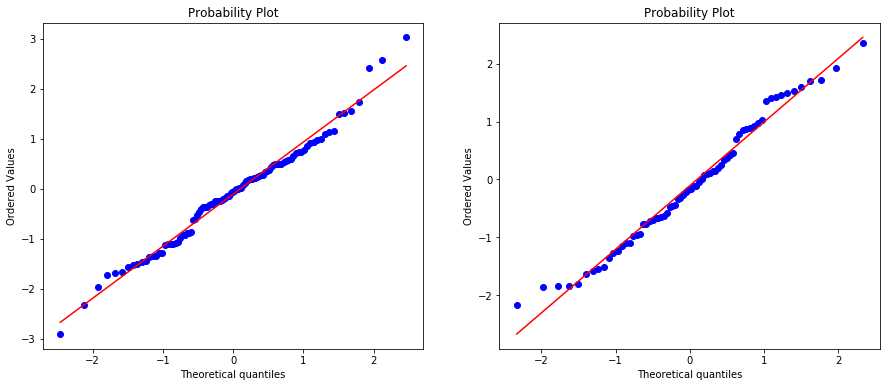

In [46]:
x_1 = np.random.randn(100)
x_2 = np.random.randn(70)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

probplot(x=x_1, plot=axes[0])
probplot(x=x_2, plot=axes[1])
plt.show()

In [47]:
x1_mean, x2_mean = np.mean(x_1), np.mean(x_2)
x1_std, x2_std = np.std(x_1), np.std(x_2)

stats = (x1_mean - x2_mean) / np.sqrt(x1_std**2/len(x_1) + x2_std**2/len(x_2))
p_value = st.norm.pdf(stats)

print(f"p_value = {round(p_value, 4)}")

p_value = 0.3989


## 4. Критерии для доли для двух независимых выборок

<img src="images/web10_ratio.png" width=400 height=400 />

In [ ]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def two_sampled_independent_samples(stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - st.norm.cdf(np.abs(stat)))
    
    if alternative == 'less':
        return st.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - st.norm.cdf(stat)

In [50]:
x_1 = np.random.randint(0, 2, size=100)
x_2 = np.random.randint(0, 2, size=250)

stat = proportions_diff_z_stat_ind(x_1, x_2)
p_value = two_sampled_independent_samples(stat)
print(f"p_value = {round(p_value, 4)}")

p_value = 0.7096


## 5. Критерии для доли для двух зависимых выборок

<img src="images/web10_ratio2.png" width=400 height=400 />

In [53]:
def proportions_diff_z_stat_rel(sample1, sample2):
    sample = list(zip(sample1, sample2))
    n = len(sample)
    
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    return float(f - g) / np.sqrt(f + g - float((f - g)**2) / n )

In [54]:
x_1 = np.random.randint(0, 2, size=100)
x_2 = np.random.randint(0, 2, size=100)

In [55]:
stat = proportions_diff_z_stat_rel(x_1, x_2)
p_value = two_sampled_independent_samples(stat)

print(f"p_value = {round(p_value, 4)}")

p_value = 0.0965


In [56]:
np.mean(x_1), np.mean(x_2)

(0.59, 0.48)